# Toronto Airbnb Listings - Spatial Analysis

## Install and import libraries

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import libpysal as lps
import esda
from esda.moran import Moran_Local
from esda.moran import Moran
import numpy as np
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster
import matplotlib.pyplot as plt 
import seaborn as sns
import folium

## Load Datasets

In [ ]:
DATAFILE = r'https://github.com/wangpengcn/Toronto-Airbnb-Spatial-Autocorrelation/blob/main/data/Toronto_AirBNB_listings_202012.csv?raw=true'
data_orig = pd.read_csv(DATAFILE)

In [ ]:
data_orig.shape

(18553, 16)

In [ ]:
data_orig.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1419,Beautiful home in amazing area!,1565,Alexandra,NaN,Little Portugal,43.64617,-79.42451,Entire home/apt,469,4,7,2017-12-04,0.11,1,0
1,8077,Downtown Harbourfront Private Room,22795,Kathie & Larry,NaN,Waterfront Communities-The Island,43.64105,-79.37628,Private room,96,180,169,2013-08-27,1.23,2,365
2,12604,Seaton Village Parlour Bedroom,48239,Rona,NaN,Annex,43.66724,-79.41598,Private room,64,1,0,NaN,NaN,1,0
3,23691,Queen Bedroom close to downtown,93825,Yohan & Sarah,NaN,Briar Hill-Belgravia,43.69602,-79.45468,Private room,70,1,217,2019-12-22,1.69,2,304
4,27423,Executive Studio Unit- Ideal for One Person,118124,Brent,NaN,Greenwood-Coxwell,43.66890,-79.32592,Entire home/apt,45,365,26,2011-08-30,0.20,1,0


Convert listings DataFrame to GeoDateFrame

In [ ]:
data_gdf = gpd.GeoDataFrame(data_orig, geometry=gpd.points_from_xy(data_orig.longitude, data_orig.latitude), crs='EPSG:4326')

Load Toronto neighbourhoods geo data

In [ ]:
DATAFILE = r'https://raw.githubusercontent.com/wangpengcn/Toronto-Airbnb-Spatial-Autocorrelation/main/data/Toronto_neighbourhoods.geojson'
nbr_gdf = gpd.read_file(DATAFILE)

In [ ]:
nbr_gdf.head(5)

,neighbourhood,neighbourhood_group,geometry
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,The Beaches,None,"MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,Scarborough Village,None,"MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,South Parkdale,None,"MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,South Riverdale,None,"MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


Spatial join the two datasets

In [ ]:
temp = data_gdf[['price','geometry']]
listing_prices = gpd.sjoin(nbr_gdf, temp, op='contains')
listing_prices.head(5)

,neighbourhood,neighbourhood_group,geometry,index_right,price
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",16744,35
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",16709,90
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",8755,50
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",12610,208
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",10578,49


Calculate average price per neighbourhood

In [ ]:
nbr_avg_price = listing_prices['price'].groupby([listing_prices['neighbourhood']]).mean()
nbr_final = nbr_gdf.merge(nbr_avg_price, on='neighbourhood')
nbr_final.rename(columns={'price': 'avg_price'}, inplace=True)
nbr_final.head()

,neighbourhood,neighbourhood_group,geometry,avg_price
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ...",58.209040
1,The Beaches,None,"MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ...",166.755102
2,Scarborough Village,None,"MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ...",76.894737
3,South Parkdale,None,"MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ...",104.728477
4,South Riverdale,None,"MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ...",148.742120


In [ ]:
toronto_coordinate = [43.70011, -79.4163]
toronto_listings = folium.Map(location=toronto_coordinate, zoom_start=11)
folium.TileLayer('CartoDB positron').add_to(toronto_listings)
mapTitle = 'Toronto Neighbourhood Airbnb Average Price 2020-12'
title_html = '''
             <h3 align="center"><b>{}</b></h3>
             '''.format(mapTitle)   
toronto_listings.get_root().html.add_child(folium.Element(title_html))
choropleth = folium.Choropleth(geo_data=nbr_final,
    data=nbr_final,
    bins=5,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',
    line_color='black',
    line_width=1,
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='Price in CAD$'
).add_to(toronto_listings)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighbourhood','avg_price'], labels=True, localize=True))
toronto_listings

In [ ]:
toronto_listings.save('toronto_airbnb_listings.html')
files.download('toronto_airbnb_listings.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot neighbourhood average price in quintiles

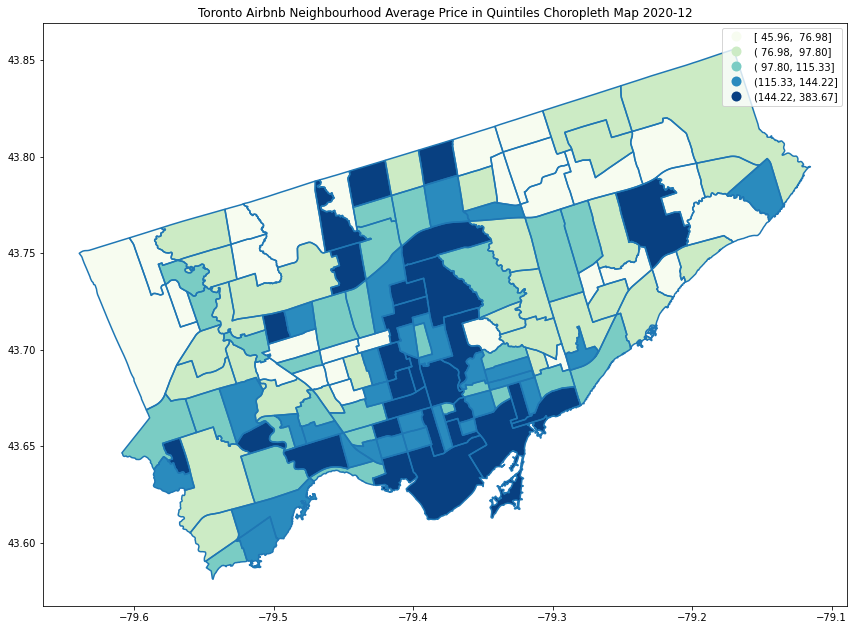

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
nbr_final.plot(column='avg_price', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax); # quintiles
nbr_final.boundary.plot(ax=ax)
plt.title('Toronto Airbnb Neighbourhood Average Price in Quintiles Choropleth Map 2020-12')
plt.tight_layout()
plt.show()

## Spatial Autocorrelation

In [ ]:
w =  lps.weights.Queen.from_dataframe(nbr_final)
w.transform = 'r'

In [ ]:
nbr_final['weighted_price'] = lps.weights.lag_spatial(w, nbr_final['avg_price'])

In [ ]:
y = nbr_final.avg_price
moran = esda.Moran(y, w)
moran.I, moran.p_sim

(0.23066396579508366, 0.001)

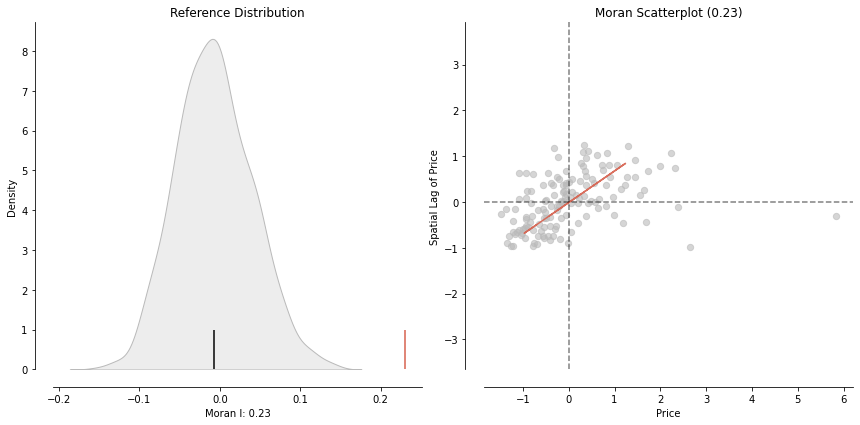

In [ ]:
plot_moran(moran, zstandard=True, figsize=(12,6))
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.tight_layout()
plt.show()

In [ ]:
m_local = Moran_Local(y, w)

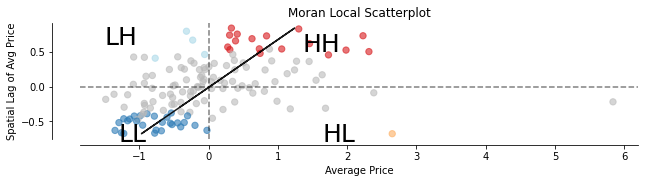

In [ ]:
P_VALUE = 0.05
fig, ax = plt.subplots(figsize=(10,10))
moran_scatterplot(m_local, p=P_VALUE, ax=ax)
ax.set_xlabel('Average Price')
ax.set_ylabel('Spatial Lag of Avg Price')
plt.text(1.35, 0.5, 'HH', fontsize=25)
plt.text(1.65, -0.8, 'HL', fontsize=25)
plt.text(-1.5, 0.6, 'LH', fontsize=25)
plt.text(-1.3, -0.8, 'LL', fontsize=25)
plt.show()

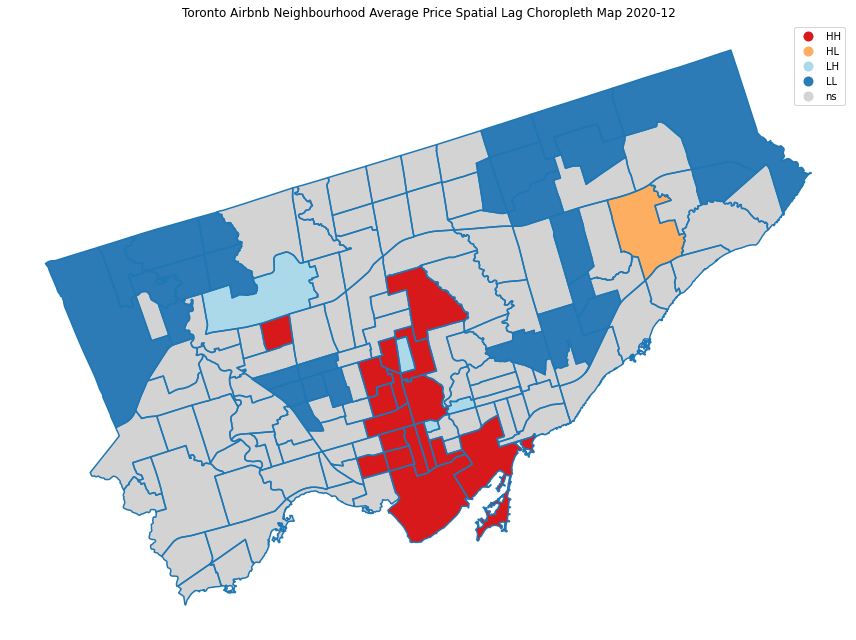

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lisa_cluster(m_local, nbr_final, p=P_VALUE, ax=ax)
nbr_final.boundary.plot(ax=ax)
plt.title('Toronto Airbnb Neighbourhood Average Price Spatial Lag Choropleth Map 2020-12')
plt.tight_layout()
plt.show()